### GAN сo скетчами ананасов

Для обучения был выбранн датасет, представлющий из себя около 1000 скетчей с ананасами.

https://github.com/evanthebouncy/pineapples

In [0]:
!git clone https://github.com/evanthebouncy/pineapples.git

In [2]:
!pip3 install pillow==4.1.1

In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing import image as im

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os

import numpy as np

from PIL import Image

Using TensorFlow backend.


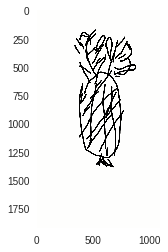

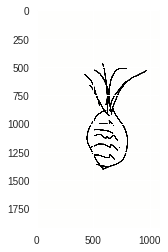

In [2]:
path = 'pineapples/drawings/'

img = Image.open(path+'sketch-1471898735605.png')
img2 = Image.open(path+'sketch-1472582806616.png')
plt.imshow(img)
plt.grid(False)
plt.show()
plt.imshow(img2)
plt.show()

In [0]:
!mkdir images

Generator, возвращающий батчи с ананасами

In [0]:
img_names = os.listdir(path)
def keras_generator(batch_size):
    while True:
        x_batch = []
        for i in range(batch_size):
            img_name = img_names[np.random.randint(0,1004)]
            img = im.load_img(path + img_name)
            img = img.convert(mode='L')
            img = img.resize((150, 300))
            img = np.expand_dims(img, axis=2)

            x_batch += [img]

        x_batch = np.array(x_batch) / 127.5 -1.
        yield x_batch

for x in keras_generator(16):
    break

In [9]:
x.shape

(16, 300, 150, 1)

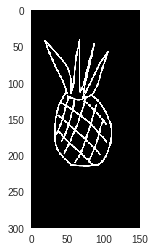

In [10]:
plt.imshow(x[0][:,:,0])
plt.grid(False)
plt.show()

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 300
        self.img_cols = 150
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 400

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()
        
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=self.img_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=self.img_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=16, sample_interval=100):

        # Load the dataset
        #X_train = keras_generator(batch_size)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            #idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = x
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()

In [13]:
gan = GAN()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 148, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 74, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 72, 16)       1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 36, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 42048)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               10764544  
_________________________________________________________________
leak

In [14]:
gan.train(epochs = 501)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.326998, acc.: 0.00%] [G loss: 0.013528]
100 [D loss: 0.018408, acc.: 100.00%] [G loss: 8.928942]
200 [D loss: 0.100208, acc.: 100.00%] [G loss: 7.666685]
300 [D loss: 0.110414, acc.: 96.88%] [G loss: 8.109848]
400 [D loss: 0.121324, acc.: 100.00%] [G loss: 9.416310]
500 [D loss: 0.035795, acc.: 100.00%] [G loss: 8.876187]


На 500-ой эпохе ган начала выдавать нечто в форме ананаса!!!

<function matplotlib.pyplot.show>

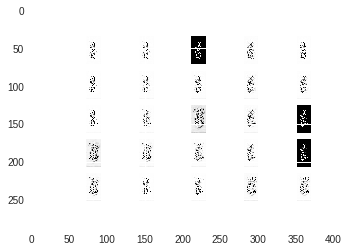

In [17]:
img = Image.open('images/500.png')
plt.imshow(img)
plt.show()